## Importing important libraries

In [1]:
!pip install einops

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 2.2 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
from torch.nn import init
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os
import numpy as np
import math
from math import exp
import cv2
from PIL import Image
import datetime
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from einops import *

## Dataset path

In [ ]:
dataset_path = '/kaggle/input/augmented-augment'

## Transformations

In [4]:
class data(Dataset):
    def __init__(self, dataset_path, transform_image=None, pad_transform=None):
        self.dataset_path = dataset_path
        self.transform_image = transform_image  # Preprocessing for images only
        self.pad_transform = pad_transform      # Padding for both images and masks
        self.images = sorted([f for f in os.listdir(os.path.join(dataset_path, 'augmented_images'))])  # Sorting images
        self.mask = sorted([f for f in os.listdir(os.path.join(dataset_path, 'augmented_masks'))])    # Sorting masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.dataset_path, 'augmented_images', self.images[idx])
        mask_path = os.path.join(self.dataset_path, 'augmented_masks', self.mask[idx])

        # Open image and mask
        image = Image.open(img_path)  # Keep original RGB format for preprocessing
        mask = Image.open(mask_path).convert("L")  # Convert mask to grayscale directly

        # Apply image-only preprocessing
        if self.transform_image:
            image = self.transform_image(image)

        # Convert the image to grayscale after preprocessing
        image = image.convert("L")

        # Apply padding to both image and mask
        if self.pad_transform:
            image = self.pad_transform(image)
            mask = self.pad_transform(mask)

        image = transforms.ToTensor()(image)
        mask = transforms.ToTensor()(mask)

        return image, mask

## Image Pre processing

In [5]:
class PreprocessImage:
    def __init__(self, kernel_size=30, gamma=1.5, clahe_clip_limit=5.0, clahe_tile_grid_size=(8, 8)):
        self.kernel_size = kernel_size
        self.gamma = gamma
        self.clahe_clip_limit = clahe_clip_limit
        self.clahe_tile_grid_size = clahe_tile_grid_size

    def __call__(self, image):
        # Convert to numpy array
        image_array = np.array(image)

        # Extract green channel
        green_channel = image_array[:, :, 1]

        # Define kernel for morphological operations
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (self.kernel_size, self.kernel_size))

        # Bottom-hat and top-hat transformations
        bottom_hat = cv2.morphologyEx(green_channel, cv2.MORPH_BLACKHAT, kernel)
        top_hat = cv2.morphologyEx(green_channel, cv2.MORPH_TOPHAT, kernel)

        # Subtract top-hat from bottom-hat
        enhanced_image = cv2.subtract(bottom_hat, top_hat)

        # CLAHE for contrast enhancement
        clahe = cv2.createCLAHE(clipLimit=self.clahe_clip_limit, tileGridSize=self.clahe_tile_grid_size)
        enhanced_image = clahe.apply(enhanced_image)

        # Gamma correction
        look_up_table = np.array([(i / 255.0) ** (1 / self.gamma) * 255 for i in range(256)]).astype("uint8")
        enhanced_image = cv2.LUT(enhanced_image, look_up_table)

        # Median blur for smoothing
        enhanced_image = cv2.medianBlur(enhanced_image, 3)

        # Morphological opening to reduce artifacts
        kernel_open = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
        enhanced_image = cv2.morphologyEx(enhanced_image, cv2.MORPH_OPEN, kernel_open)

        # Convert back to PIL Image
        return Image.fromarray(enhanced_image)

## Splitting into tiles

In [6]:
class SlidingWindowDataset(Dataset):
    def __init__(self, dataset, tile_size=256):
        self.dataset = dataset
        self.tile_size = tile_size

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Load the original padded image and mask pair
        image, mask = self.dataset[idx]  # Assuming dataset returns (image, mask)

        image=rearrange(image, 'c (h p1) (w p2) -> (h w) c p1 p2', p1=256, p2=256)
        mask=rearrange(mask, 'c (h p1) (w p2) -> (h w) c p1 p2', p1=256, p2=256)

        return image, mask


## Data Transformation

In [7]:
preprocess_transform = PreprocessImage()
pad_transform = transforms.Pad((0, 32, 25, 32))

dataset = data(
    dataset_path=dataset_path,
    transform_image=preprocess_transform,
    pad_transform=pad_transform
)

# Split into Train and Test Sets (80% train, 20% test)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Wrap the training and test sets with the SlidingWindowDataset to apply sliding window
train_sliding_dataset = SlidingWindowDataset(train_dataset)
test_sliding_dataset = SlidingWindowDataset(test_dataset)

# Create DataLoaders
train_loader = DataLoader(train_sliding_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_sliding_dataset, batch_size=1, shuffle=False)

## Defining loss functions

In [8]:
# #PyTorch
# class DiceBCELoss(nn.Module):
#     def __init__(self, weight=None, size_average=True):
#         super(DiceBCELoss, self).__init__()

#     def forward(self, inputs, targets, smooth=1):
        
#         inputs = F.sigmoid(inputs)   
    
#         #flatten label and prediction tensors
#         inputs = inputs.view(-1)
#         targets = targets.view(-1)
        
#         intersection = (inputs * targets).sum()                            
#         dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
#         BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
#         Dice_BCE = 0.5*BCE + dice_loss
        
#         return Dice_BCE

In [10]:
class IoUSensitivityLoss(nn.Module):
    def __init__(self):
        super(IoUSensitivityLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = torch.sigmoid(inputs)  # Ensure inputs go through Sigmoid
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        # IoU Loss
        intersection_iou = (inputs * targets).sum()
        union = inputs.sum() + targets.sum() - intersection_iou
        iou_loss = 1 - (intersection_iou + smooth) / (union + smooth)

        # Sensitivity Loss
        TP = (inputs * targets).sum()  # True Positives
        FN = ((1 - inputs) * targets).sum()  # False Negatives
        sensitivity = TP / (TP + FN + smooth)  # Smooth term for numerical stability
        sensitivity_loss = 1 - sensitivity


        # Combined Loss
        loss = iou_loss + 0.3 * sensitivity_loss
        return loss

## UNet3+ Implementation

In [11]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    #print(classname)
    if classname.find('Conv') != -1:
        init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('Linear') != -1:
        init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        init.normal_(m.weight.data, 1.0, 0.02)
        init.constant_(m.bias.data, 0.0)


def weights_init_xavier(m):
    classname = m.__class__.__name__
    #print(classname)
    if classname.find('Conv') != -1:
        init.xavier_normal_(m.weight.data, gain=1)
    elif classname.find('Linear') != -1:
        init.xavier_normal_(m.weight.data, gain=1)
    elif classname.find('BatchNorm') != -1:
        init.normal_(m.weight.data, 1.0, 0.02)
        init.constant_(m.bias.data, 0.0)


def weights_init_kaiming(m):
    classname = m.__class__.__name__
    #print(classname)
    if classname.find('Conv') != -1:
        init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
    elif classname.find('Linear') != -1:
        init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
    elif classname.find('BatchNorm') != -1:
        init.normal_(m.weight.data, 1.0, 0.02)
        init.constant_(m.bias.data, 0.0)


def weights_init_orthogonal(m):
    classname = m.__class__.__name__
    #print(classname)
    if classname.find('Conv') != -1:
        init.orthogonal_(m.weight.data, gain=1)
    elif classname.find('Linear') != -1:
        init.orthogonal_(m.weight.data, gain=1)
    elif classname.find('BatchNorm') != -1:
        init.normal_(m.weight.data, 1.0, 0.02)
        init.constant_(m.bias.data, 0.0)

In [12]:
def init_weights(net, init_type='normal'):
    #print('initialization method [%s]' % init_type)
    if init_type == 'normal':
        net.apply(weights_init_normal)
    elif init_type == 'xavier':
        net.apply(weights_init_xavier)
    elif init_type == 'kaiming':
        net.apply(weights_init_kaiming)
    elif init_type == 'orthogonal':
        net.apply(weights_init_orthogonal)
    else:
        raise NotImplementedError('initialization method [%s] is not implemented' % init_type)

In [13]:
class unetConv2(nn.Module):
    def __init__(self, in_size, out_size, is_batchnorm, n=2, ks=3, stride=1, padding=1):
        super(unetConv2, self).__init__()
        self.n = n
        self.ks = ks
        self.stride = stride
        self.padding = padding
        s = stride
        p = padding
        if is_batchnorm:
            for i in range(1, n + 1):
                conv = nn.Sequential(nn.Conv2d(in_size, out_size, ks, s, p),
                                     nn.BatchNorm2d(out_size),
                                     nn.ReLU(inplace=True), )
                setattr(self, 'conv%d' % i, conv)
                in_size = out_size

        else:
            for i in range(1, n + 1):
                conv = nn.Sequential(nn.Conv2d(in_size, out_size, ks, s, p),
                                     nn.ReLU(inplace=True), )
                setattr(self, 'conv%d' % i, conv)
                in_size = out_size

        # initialise the blocks
        for m in self.children():
            init_weights(m, init_type='kaiming')

    def forward(self, inputs):
        x = inputs
        for i in range(1, self.n + 1):
            conv = getattr(self, 'conv%d' % i)
            x = conv(x)

        return x

In [14]:
class UNet_3Plus(nn.Module):

    def __init__(self, in_channels=3, n_classes=1, feature_scale=4, is_deconv=True, is_batchnorm=True):
        super(UNet_3Plus, self).__init__()
        self.is_deconv = is_deconv
        self.in_channels = in_channels
        self.is_batchnorm = is_batchnorm
        self.feature_scale = feature_scale

        filters = [64, 128, 256, 512, 1024]

        ## -------------Encoder--------------
        self.conv1 = unetConv2(self.in_channels, filters[0], self.is_batchnorm)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2 = unetConv2(filters[0], filters[1], self.is_batchnorm)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)

        self.conv3 = unetConv2(filters[1], filters[2], self.is_batchnorm)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)

        self.conv4 = unetConv2(filters[2], filters[3], self.is_batchnorm)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2)

        self.conv5 = unetConv2(filters[3], filters[4], self.is_batchnorm)

        ## -------------Decoder--------------
        self.CatChannels = filters[0]
        self.CatBlocks = 5
        self.UpChannels = self.CatChannels * self.CatBlocks

        '''stage 4d'''
        # h1->320*320, hd4->40*40, Pooling 8 times
        self.h1_PT_hd4 = nn.MaxPool2d(8, 8, ceil_mode=True)
        self.h1_PT_hd4_conv = nn.Conv2d(filters[0], self.CatChannels, 3, padding=1)
        self.h1_PT_hd4_bn = nn.BatchNorm2d(self.CatChannels)
        self.h1_PT_hd4_relu = nn.ReLU(inplace=True)

        # h2->160*160, hd4->40*40, Pooling 4 times
        self.h2_PT_hd4 = nn.MaxPool2d(4, 4, ceil_mode=True)
        self.h2_PT_hd4_conv = nn.Conv2d(filters[1], self.CatChannels, 3, padding=1)
        self.h2_PT_hd4_bn = nn.BatchNorm2d(self.CatChannels)
        self.h2_PT_hd4_relu = nn.ReLU(inplace=True)

        # h3->80*80, hd4->40*40, Pooling 2 times
        self.h3_PT_hd4 = nn.MaxPool2d(2, 2, ceil_mode=True)
        self.h3_PT_hd4_conv = nn.Conv2d(filters[2], self.CatChannels, 3, padding=1)
        self.h3_PT_hd4_bn = nn.BatchNorm2d(self.CatChannels)
        self.h3_PT_hd4_relu = nn.ReLU(inplace=True)

        # h4->40*40, hd4->40*40, Concatenation
        self.h4_Cat_hd4_conv = nn.Conv2d(filters[3], self.CatChannels, 3, padding=1)
        self.h4_Cat_hd4_bn = nn.BatchNorm2d(self.CatChannels)
        self.h4_Cat_hd4_relu = nn.ReLU(inplace=True)

        # hd5->20*20, hd4->40*40, Upsample 2 times
        self.hd5_UT_hd4 = nn.Upsample(scale_factor=2, mode='bilinear')  # 14*14
        self.hd5_UT_hd4_conv = nn.Conv2d(filters[4], self.CatChannels, 3, padding=1)
        self.hd5_UT_hd4_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd5_UT_hd4_relu = nn.ReLU(inplace=True)

        # fusion(h1_PT_hd4, h2_PT_hd4, h3_PT_hd4, h4_Cat_hd4, hd5_UT_hd4)
        self.conv4d_1 = nn.Conv2d(self.UpChannels, self.UpChannels, 3, padding=1)  # 16
        self.bn4d_1 = nn.BatchNorm2d(self.UpChannels)
        self.relu4d_1 = nn.ReLU(inplace=True)

        '''stage 3d'''
        # h1->320*320, hd3->80*80, Pooling 4 times
        self.h1_PT_hd3 = nn.MaxPool2d(4, 4, ceil_mode=True)
        self.h1_PT_hd3_conv = nn.Conv2d(filters[0], self.CatChannels, 3, padding=1)
        self.h1_PT_hd3_bn = nn.BatchNorm2d(self.CatChannels)
        self.h1_PT_hd3_relu = nn.ReLU(inplace=True)

        # h2->160*160, hd3->80*80, Pooling 2 times
        self.h2_PT_hd3 = nn.MaxPool2d(2, 2, ceil_mode=True)
        self.h2_PT_hd3_conv = nn.Conv2d(filters[1], self.CatChannels, 3, padding=1)
        self.h2_PT_hd3_bn = nn.BatchNorm2d(self.CatChannels)
        self.h2_PT_hd3_relu = nn.ReLU(inplace=True)

        # h3->80*80, hd3->80*80, Concatenation
        self.h3_Cat_hd3_conv = nn.Conv2d(filters[2], self.CatChannels, 3, padding=1)
        self.h3_Cat_hd3_bn = nn.BatchNorm2d(self.CatChannels)
        self.h3_Cat_hd3_relu = nn.ReLU(inplace=True)
        
        # hd4->40*40, hd3->80*80, Upsample 2 times
        self.hd4_UT_hd3 = nn.Upsample(scale_factor=2, mode='bilinear')  # 14*14
        self.hd4_UT_hd3_conv = nn.Conv2d(self.UpChannels, self.CatChannels, 3, padding=1)
        self.hd4_UT_hd3_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd4_UT_hd3_relu = nn.ReLU(inplace=True)

        # hd5->20*20, hd2->80*80, Upsample 4 times
        self.hd5_UT_hd3 = nn.Upsample(scale_factor=4, mode='bilinear')  # 14*14
        self.hd5_UT_hd3_conv = nn.Conv2d(filters[4], self.CatChannels, 3, padding=1)
        self.hd5_UT_hd3_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd5_UT_hd3_relu = nn.ReLU(inplace=True)
        
        # fusion(h1_PT_hd2, h2_Cat_hd2, hd3_UT_hd2, hd4_UT_hd2, hd5_UT_hd2)
        self.conv3d_1 = nn.Conv2d(self.UpChannels, self.UpChannels, 3, padding=1)  # 16
        self.bn3d_1 = nn.BatchNorm2d(self.UpChannels)
        self.relu3d_1 = nn.ReLU(inplace=True)

        '''stage 2d'''
        # h1->360*360, hd2->160*160, Pooling 2 times
        self.h1_PT_hd2 = nn.MaxPool2d(2, 2, ceil_mode=True)
        self.h1_PT_hd2_conv = nn.Conv2d(filters[0], self.CatChannels, 3, padding=1)
        self.h1_PT_hd2_bn = nn.BatchNorm2d(self.CatChannels)
        self.h1_PT_hd2_relu = nn.ReLU(inplace=True)
        
        # h2->160*160, hd2->160*160, Concatenation
        self.h2_Cat_hd2_conv = nn.Conv2d(filters[1], self.CatChannels, 3, padding=1)
        self.h2_Cat_hd2_bn = nn.BatchNorm2d(self.CatChannels)
        self.h2_Cat_hd2_relu = nn.ReLU(inplace=True)

        # hd3->80*80, hd2->160*160, Upsample 2 times
        self.hd3_UT_hd2 = nn.Upsample(scale_factor=2, mode='bilinear')  # 14*14
        self.hd3_UT_hd2_conv = nn.Conv2d(self.UpChannels, self.CatChannels, 3, padding=1)
        self.hd3_UT_hd2_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd3_UT_hd2_relu = nn.ReLU(inplace=True)

        # hd4->40*40, hd2->160*160, Upsample 4 times
        self.hd4_UT_hd2 = nn.Upsample(scale_factor=4, mode='bilinear')  # 14*14
        self.hd4_UT_hd2_conv = nn.Conv2d(self.UpChannels, self.CatChannels, 3, padding=1)
        self.hd4_UT_hd2_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd4_UT_hd2_relu = nn.ReLU(inplace=True)

        # hd5->20*20, hd2->160*160, Upsample 8 times
        self.hd5_UT_hd2 = nn.Upsample(scale_factor=8, mode='bilinear')  # 14*14
        self.hd5_UT_hd2_conv = nn.Conv2d(filters[4], self.CatChannels, 3, padding=1)
        self.hd5_UT_hd2_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd5_UT_hd2_relu = nn.ReLU(inplace=True)

        # fusion(h1_PT_hd2, h2_Cat_hd2, hd3_UT_hd2, hd4_UT_hd2, hd5_UT_hd2)
        self.conv2d_1 = nn.Conv2d(self.UpChannels, self.UpChannels, 3, padding=1)  # 16
        self.bn2d_1 = nn.BatchNorm2d(self.UpChannels)
        self.relu2d_1 = nn.ReLU(inplace=True)

        '''stage 1d'''
        # h1->320*320, hd1->320*320, Concatenation
        self.h1_Cat_hd1_conv = nn.Conv2d(filters[0], self.CatChannels, 3, padding=1)
        self.h1_Cat_hd1_bn = nn.BatchNorm2d(self.CatChannels)
        self.h1_Cat_hd1_relu = nn.ReLU(inplace=True)

        # hd2->160*160, hd1->320*320, Upsample 2 times
        self.hd2_UT_hd1 = nn.Upsample(scale_factor=2, mode='bilinear')  # 14*14
        self.hd2_UT_hd1_conv = nn.Conv2d(self.UpChannels, self.CatChannels, 3, padding=1)
        self.hd2_UT_hd1_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd2_UT_hd1_relu = nn.ReLU(inplace=True)

        # hd3->80*80, hd1->320*320, Upsample 4 times
        self.hd3_UT_hd1 = nn.Upsample(scale_factor=4, mode='bilinear')  # 14*14
        self.hd3_UT_hd1_conv = nn.Conv2d(self.UpChannels, self.CatChannels, 3, padding=1)
        self.hd3_UT_hd1_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd3_UT_hd1_relu = nn.ReLU(inplace=True)

        # hd4->40*40, hd1->320*320, Upsample 8 times
        self.hd4_UT_hd1 = nn.Upsample(scale_factor=8, mode='bilinear')  # 14*14
        self.hd4_UT_hd1_conv = nn.Conv2d(self.UpChannels, self.CatChannels, 3, padding=1)
        self.hd4_UT_hd1_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd4_UT_hd1_relu = nn.ReLU(inplace=True)

        # hd5->20*20, hd1->320*320, Upsample 16 times
        self.hd5_UT_hd1 = nn.Upsample(scale_factor=16, mode='bilinear')  # 14*14
        self.hd5_UT_hd1_conv = nn.Conv2d(filters[4], self.CatChannels, 3, padding=1)
        self.hd5_UT_hd1_bn = nn.BatchNorm2d(self.CatChannels)
        self.hd5_UT_hd1_relu = nn.ReLU(inplace=True)

        # fusion(h1_Cat_hd1, hd2_UT_hd1, hd3_UT_hd1, hd4_UT_hd1, hd5_UT_hd1)
        self.conv1d_1 = nn.Conv2d(self.UpChannels, self.UpChannels, 3, padding=1)  # 16
        self.bn1d_1 = nn.BatchNorm2d(self.UpChannels)
        self.relu1d_1 = nn.ReLU(inplace=True)

        # output
        self.outconv1 = nn.Conv2d(self.UpChannels, n_classes, 3, padding=1)

        # initialise weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init_weights(m, init_type='kaiming')
            elif isinstance(m, nn.BatchNorm2d):
                init_weights(m, init_type='kaiming')

    def forward(self, inputs):
        ## -------------Encoder-------------
        h1 = self.conv1(inputs)  # h1->320*320*64

        h2 = self.maxpool1(h1)
        h2 = self.conv2(h2)  # h2->160*160*128

        h3 = self.maxpool2(h2)
        h3 = self.conv3(h3)  # h3->80*80*256

        h4 = self.maxpool3(h3)
        h4 = self.conv4(h4)  # h4->40*40*512

        h5 = self.maxpool4(h4)
        hd5 = self.conv5(h5)  # h5->20*20*1024

        ## -------------Decoder-------------
        h1_PT_hd4 = self.h1_PT_hd4_relu(self.h1_PT_hd4_bn(self.h1_PT_hd4_conv(self.h1_PT_hd4(h1))))
        h2_PT_hd4 = self.h2_PT_hd4_relu(self.h2_PT_hd4_bn(self.h2_PT_hd4_conv(self.h2_PT_hd4(h2))))
        h3_PT_hd4 = self.h3_PT_hd4_relu(self.h3_PT_hd4_bn(self.h3_PT_hd4_conv(self.h3_PT_hd4(h3))))
        h4_Cat_hd4 = self.h4_Cat_hd4_relu(self.h4_Cat_hd4_bn(self.h4_Cat_hd4_conv(h4)))
        hd5_UT_hd4 = self.hd5_UT_hd4_relu(self.hd5_UT_hd4_bn(self.hd5_UT_hd4_conv(self.hd5_UT_hd4(hd5))))
        hd4 = self.relu4d_1(self.bn4d_1(self.conv4d_1(
            torch.cat((h1_PT_hd4, h2_PT_hd4, h3_PT_hd4, h4_Cat_hd4, hd5_UT_hd4), 1)))) # hd4->40*40*UpChannels

        h1_PT_hd3 = self.h1_PT_hd3_relu(self.h1_PT_hd3_bn(self.h1_PT_hd3_conv(self.h1_PT_hd3(h1))))
        h2_PT_hd3 = self.h2_PT_hd3_relu(self.h2_PT_hd3_bn(self.h2_PT_hd3_conv(self.h2_PT_hd3(h2))))
        h3_Cat_hd3 = self.h3_Cat_hd3_relu(self.h3_Cat_hd3_bn(self.h3_Cat_hd3_conv(h3)))
        hd4_UT_hd3 = self.hd4_UT_hd3_relu(self.hd4_UT_hd3_bn(self.hd4_UT_hd3_conv(self.hd4_UT_hd3(hd4))))
        hd5_UT_hd3 = self.hd5_UT_hd3_relu(self.hd5_UT_hd3_bn(self.hd5_UT_hd3_conv(self.hd5_UT_hd3(hd5))))
        hd3 = self.relu3d_1(self.bn3d_1(self.conv3d_1(
            torch.cat((h1_PT_hd3, h2_PT_hd3, h3_Cat_hd3, hd4_UT_hd3, hd5_UT_hd3), 1)))) # hd3->80*80*UpChannels

        h1_PT_hd2 = self.h1_PT_hd2_relu(self.h1_PT_hd2_bn(self.h1_PT_hd2_conv(self.h1_PT_hd2(h1))))
        h2_Cat_hd2 = self.h2_Cat_hd2_relu(self.h2_Cat_hd2_bn(self.h2_Cat_hd2_conv(h2)))
        hd3_UT_hd2 = self.hd3_UT_hd2_relu(self.hd3_UT_hd2_bn(self.hd3_UT_hd2_conv(self.hd3_UT_hd2(hd3))))
        hd4_UT_hd2 = self.hd4_UT_hd2_relu(self.hd4_UT_hd2_bn(self.hd4_UT_hd2_conv(self.hd4_UT_hd2(hd4))))
        hd5_UT_hd2 = self.hd5_UT_hd2_relu(self.hd5_UT_hd2_bn(self.hd5_UT_hd2_conv(self.hd5_UT_hd2(hd5))))
        hd2 = self.relu2d_1(self.bn2d_1(self.conv2d_1(
            torch.cat((h1_PT_hd2, h2_Cat_hd2, hd3_UT_hd2, hd4_UT_hd2, hd5_UT_hd2), 1)))) # hd2->160*160*UpChannels

        h1_Cat_hd1 = self.h1_Cat_hd1_relu(self.h1_Cat_hd1_bn(self.h1_Cat_hd1_conv(h1)))
        hd2_UT_hd1 = self.hd2_UT_hd1_relu(self.hd2_UT_hd1_bn(self.hd2_UT_hd1_conv(self.hd2_UT_hd1(hd2))))
        hd3_UT_hd1 = self.hd3_UT_hd1_relu(self.hd3_UT_hd1_bn(self.hd3_UT_hd1_conv(self.hd3_UT_hd1(hd3))))
        hd4_UT_hd1 = self.hd4_UT_hd1_relu(self.hd4_UT_hd1_bn(self.hd4_UT_hd1_conv(self.hd4_UT_hd1(hd4))))
        hd5_UT_hd1 = self.hd5_UT_hd1_relu(self.hd5_UT_hd1_bn(self.hd5_UT_hd1_conv(self.hd5_UT_hd1(hd5))))
        hd1 = self.relu1d_1(self.bn1d_1(self.conv1d_1(
            torch.cat((h1_Cat_hd1, hd2_UT_hd1, hd3_UT_hd1, hd4_UT_hd1, hd5_UT_hd1), 1)))) # hd1->320*320*UpChannels

        d1 = self.outconv1(hd1)  # d1->320*320*n_classes
        return F.sigmoid(d1)

## Metrics for testing data

In [15]:
def accuracy(pred, target):
    pred_binary = pred > 0.5  # Assuming threshold of 0.5 for binary segmentation
    correct = (pred_binary == target).sum().item()
    total = target.numel()
    return correct / total

In [16]:
def sensitivity(pred, target):
    pred_binary = pred > 0.5
    TP = ((pred_binary == 1) & (target == 1)).sum().item()
    FN = ((pred_binary == 0) & (target == 1)).sum().item()
    return TP / (TP + FN + 1e-8)

In [17]:
def specificity(pred, target):
    pred_binary = pred > 0.5
    TN = ((pred_binary == 0) & (target == 0)).sum().item()
    FP = ((pred_binary == 1) & (target == 0)).sum().item()
    return TN / (TN + FP + 1e-8)

In [18]:
def mcc(pred, target):
    pred_binary = pred > 0.5
    TP = ((pred_binary == 1) & (target == 1)).sum().item()
    TN = ((pred_binary == 0) & (target == 0)).sum().item()
    FP = ((pred_binary == 1) & (target == 0)).sum().item()
    FN = ((pred_binary == 0) & (target == 1)).sum().item()
    numerator = (TP * TN) - (FP * FN)
    denominator = math.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN) + 1e-8)
    return numerator / denominator if denominator else 0

In [19]:
def iou(pred, target):
    # Convert tensors to boolean by comparing with a threshold
    pred_binary = (pred > 0.5).bool()
    target_binary = target.bool()
    
    # Calculate intersection and union
    intersection = (pred_binary & target_binary).sum().item()
    union = (pred_binary | target_binary).sum().item()
    
    # Return IoU score
    return intersection / (union + 1e-8)

In [20]:
def dice_coefficient(pred, target):
    pred_binary = (pred > 0.5).bool()
    target_binary = target.bool()  # Ensure target is also a boolean tensor
    intersection = (pred_binary & target_binary).sum().item()
    return (2 * intersection) / (pred_binary.sum().item() + target_binary.sum().item() + 1e-8)


In [21]:
def ppv(pred, target):
    pred_binary = pred > 0.5
    TP = ((pred_binary == 1) & (target == 1)).sum().item()
    FP = ((pred_binary == 1) & (target == 0)).sum().item()
    return TP / (TP + FP + 1e-8)

## Tensorboard

In [22]:
!rm -rf /kaggle/working/logs

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [23]:
!mkdir /kaggle/working/logs

In [24]:
!wget https://bin.equinox.io/c/bNyj1mQVY4c/ngrok-v3-stable-linux-amd64.tgz
!tar -xvzf ngrok-v3-stable-linux-amd64.tgz

--2024-11-19 17:23:44--  https://bin.equinox.io/c/bNyj1mQVY4c/ngrok-v3-stable-linux-amd64.tgz
Resolving bin.equinox.io (bin.equinox.io)... 99.83.220.108, 35.71.179.82, 13.248.244.96, ...
Connecting to bin.equinox.io (bin.equinox.io)|99.83.220.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14796857 (14M) [application/octet-stream]
Saving to: 'ngrok-v3-stable-linux-amd64.tgz'

ngrok-v3-stable-lin 100%[===================>]  14.11M  30.7MB/s    in 0.5s    

2024-11-19 17:23:45 (30.7 MB/s) - 'ngrok-v3-stable-linux-amd64.tgz' saved [14796857/14796857]

ngrok


In [ ]:
!./ngrok config add-authtoken "API TOKEN"

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [26]:
import os
import multiprocessing


pool = multiprocessing.Pool(processes = 10)
results_of_processes = [pool.apply_async(os.system, args=(cmd, ), callback = None )
                        for cmd in [
                        f"tensorboard --logdir /kaggle/working/logs --host 0.0.0.0 --port 6006 &",
                        "./ngrok http 6006 &"
                        ]]


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [27]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://92e6-34-105-93-21.ngrok-free.app


## Training model

In [ ]:
from tqdm import tqdm  # Import tqdm for progress bar
import datetime
import os
from torch.utils.tensorboard import SummaryWriter

if __name__ == "__main__":
    # Initialize your model
    model = UNet_3Plus(in_channels=1).cuda()
    model.load_state_dict(torch.load('/kaggle/input/model-iou/latest_model.pth'))
    model.train()

    # Define loss function and optimizer
    criterion = IoUSensitivityLoss().cuda()
    # optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)

    logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    writer = SummaryWriter(log_dir=logdir)

    # Training loop
    num_epochs = 100
    batch_size = 2
    for epoch in range(num_epochs):
        running_loss = 0.0
        accuracy_scores = []
        senstivity_scores = []
        specificity_scores = []
        mcc_scores = []
        iou_scores = []
        ppv_scores = []
        dice_scores = []

        # Add tqdm to track the batch loop
        with tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch") as pbar:
            for images, masks in train_loader:
                # print(images.shape)
                images_batches = images.view(4,4, images.size(2), images.size(3), images.size(4))
                masks_batches = masks.view(4,4, masks.size(2), masks.size(3), masks.size(4))

                for images,masks in zip(images_batches,masks_batches):
                    # Forward pass
                    images, masks = images.cuda(), masks.cuda()
                    
                    # print("Initial images shape:", images.shape)
                    # print("Initial masks shape:", masks.shape)
                    main_output = model(images)
                    loss = criterion(main_output, masks)
    
                    
                    acc = accuracy(main_output, masks)
                    sens = sensitivity(main_output, masks)
                    spec = specificity(main_output, masks)
                    mccM = mcc(main_output, masks)
                    iouM = iou(main_output, masks)
                    ppvM = ppv(main_output, masks)
                    dice = dice_coefficient(main_output, masks)
    
                    # Backward pass
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
    
                    running_loss += loss.item()
                    accuracy_scores.append(acc)
                    senstivity_scores.append(sens)
                    specificity_scores.append(spec)
                    mcc_scores.append(mccM)
                    iou_scores.append(iouM)
                    ppv_scores.append(ppvM)
                    dice_scores.append(dice)
    
                    # Log final output image to TensorBoard
                    output_image = main_output[0].cpu().detach()
                    # Remove the extra batch dimension from mask_image
                    image=images[0].cpu().detach()
                    mask_image = masks[0].cpu().detach()
                    writer.add_image("Output/input", image, epoch, dataformats="CHW")

                    writer.add_image("Output/ground_truth", mask_image, epoch, dataformats="CHW")
                    writer.add_image("Output/final_prediction", output_image, epoch, dataformats="CHW")
                # Update tqdm progress bar
                pbar.update(1)
                pbar.set_postfix({"loss": loss.item(), "iou": iouM})

        # Calculate average metrics
        average_loss = running_loss / (len(train_loader)*4)
        average_accuracy = sum(accuracy_scores) / (len(accuracy_scores))
        average_sens = sum(senstivity_scores) / (len(senstivity_scores))
        average_spec = sum(specificity_scores) / (len(specificity_scores))
        average_mcc = sum(mcc_scores) / (len(mcc_scores))
        average_iou = sum(iou_scores) / (len(iou_scores))
        average_ppv = sum(ppv_scores) / (len(ppv_scores))
        average_dice = sum(dice_scores) / (len(dice_scores))

        # Log metrics to TensorBoard
        writer.add_scalar("Loss/train", average_loss, epoch)
        writer.add_scalar("Accuracy/train", average_accuracy, epoch)
        writer.add_scalar("Sensitivity/train", average_sens, epoch)
        writer.add_scalar("Specificity/train", average_spec, epoch)
        writer.add_scalar("MCC/train", average_mcc, epoch)
        writer.add_scalar("IOU/train", average_iou, epoch)
        writer.add_scalar("PPV/train", average_ppv, epoch)
        writer.add_scalar("Dice/train", average_dice, epoch)
        writer.add_scalar("Learning Rate", optimizer.param_groups[0]["lr"], epoch)  # Log LR

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss}, Accuracy: {average_accuracy}, "
              f"Sensitivity: {average_sens}, Specificity: {average_spec}, MCC: {average_mcc}, "
              f"IOU: {average_iou}, PPV: {average_ppv}, DICE: {average_dice}")
        torch.save(model.state_dict(), '/kaggle/working/latest_model.pth')
        print(f"Model saved at epoch {epoch + 1}")

    writer.close()


/tmp/ipykernel_30/1390238946.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/kaggle/input/model-iou/latest_model.pth'))
Epoch 1/100:  

Epoch [1/100], Loss: 0.9984392687412245, Accuracy: 0.9753382972308567, Sensitivity: 0.9825743701889397, Specificity: 0.9747483194015503, MCC: 0.8058564663991002, IOU: 0.680172964330018, PPV: 0.6882190801863131, DICE: 0.7995088195407207
Model saved at epoch 1


Epoch 2/100: 100%|██████████| 112/112 [05:25<00:00,  2.91s/batch, loss=1.04, iou=0.391]


Epoch [2/100], Loss: 0.9981017169941749, Accuracy: 0.9750787700925555, Sensitivity: 0.985916625959302, Specificity: 0.9743862741724282, MCC: 0.7963808381399808, IOU: 0.6662166384317336, PPV: 0.6726176180504589, DICE: 0.7869671176622639
Model saved at epoch 2


Epoch 3/100: 100%|██████████| 112/112 [05:25<00:00,  2.90s/batch, loss=1.03, iou=0.659]


Epoch [3/100], Loss: 0.997833921307964, Accuracy: 0.9783282365117755, Sensitivity: 0.9878617369997312, Specificity: 0.977717155495698, MCC: 0.8157084599800758, IOU: 0.6927749483870845, PPV: 0.6987960915789972, DICE: 0.8087222259981406
Model saved at epoch 3


Epoch 4/100: 100%|██████████| 112/112 [05:25<00:00,  2.90s/batch, loss=1.02, iou=0.786]


Epoch [4/100], Loss: 0.997629590199462, Accuracy: 0.9810031482151577, Sensitivity: 0.9892676093205593, Specificity: 0.9804491711498169, MCC: 0.8344831256316807, IOU: 0.7199762551404442, PPV: 0.7257397731785212, DICE: 0.8296763398797944
Model saved at epoch 4


Epoch 5/100: 100%|██████████| 112/112 [05:25<00:00,  2.90s/batch, loss=1.03, iou=0.743]


Epoch [5/100], Loss: 0.9975230053865484, Accuracy: 0.9816926036562238, Sensitivity: 0.9901682761738397, Specificity: 0.9811406449036398, MCC: 0.8392522950193181, IOU: 0.7269442172470688, PPV: 0.7323521151164333, DICE: 0.8347626911438786
Model saved at epoch 5


Epoch 6/100: 100%|██████████| 112/112 [05:25<00:00,  2.91s/batch, loss=1.03, iou=0.699]


Epoch [6/100], Loss: 0.997430524921843, Accuracy: 0.9822690912655422, Sensitivity: 0.9909356546876955, Specificity: 0.9817147086468916, MCC: 0.8427682649507007, IOU: 0.7323699206365932, PPV: 0.7374842963797837, DICE: 0.8383848248859712
Model saved at epoch 6


Epoch 7/100: 100%|██████████| 112/112 [05:25<00:00,  2.91s/batch, loss=1, iou=0.713]   


Epoch [7/100], Loss: 0.9973963130531567, Accuracy: 0.9819198335920062, Sensitivity: 0.991470187616233, Specificity: 0.9813062600897526, MCC: 0.8406536313856504, IOU: 0.7288690600607161, PPV: 0.7336868779337938, DICE: 0.8360375139717665
Model saved at epoch 7


Epoch 8/100: 100%|██████████| 112/112 [05:25<00:00,  2.91s/batch, loss=1.05, iou=0.612]


Epoch [8/100], Loss: 0.9973885724321008, Accuracy: 0.9809230991772243, Sensitivity: 0.9918421983460031, Specificity: 0.9802436412034112, MCC: 0.8332362025602015, IOU: 0.7179094587430869, PPV: 0.7224890682834378, DICE: 0.8274747409549504
Model saved at epoch 8


Epoch 9/100: 100%|██████████| 112/112 [05:25<00:00,  2.91s/batch, loss=1.02, iou=0.806]


Epoch [9/100], Loss: 0.9972827180421778, Accuracy: 0.9826815213475909, Sensitivity: 0.9924811855277252, Specificity: 0.9820501264543423, MCC: 0.846755605133142, IOU: 0.7378465699476964, PPV: 0.7422607176222485, DICE: 0.8427458090776062
Model saved at epoch 9


Epoch 10/100: 100%|██████████| 112/112 [05:25<00:00,  2.91s/batch, loss=1.03, iou=0.691]


Epoch [10/100], Loss: 0.9972319108034883, Accuracy: 0.9834371549742562, Sensitivity: 0.9928115001926177, Specificity: 0.9828238284985347, MCC: 0.8529967562231399, IOU: 0.7472941027019816, PPV: 0.7516024875758271, DICE: 0.8497319829675568
Model saved at epoch 10


Epoch 11/100: 100%|██████████| 112/112 [05:25<00:00,  2.91s/batch, loss=1.05, iou=0.559]


Epoch [11/100], Loss: 0.997210136747786, Accuracy: 0.9834773114749363, Sensitivity: 0.9930730546236328, Specificity: 0.9828390025517121, MCC: 0.8537000054924061, IOU: 0.7482504857404023, PPV: 0.7524077959292441, DICE: 0.8505811250226977
Model saved at epoch 11


Epoch 12/100: 100%|██████████| 112/112 [05:25<00:00,  2.91s/batch, loss=1.05, iou=0.522]


Epoch [12/100], Loss: 0.997217016959829, Accuracy: 0.9830473065376282, Sensitivity: 0.9931743073043915, Specificity: 0.9823788710432397, MCC: 0.8508286064959174, IOU: 0.7436708080492636, PPV: 0.747761217034956, DICE: 0.8474797695402358
Model saved at epoch 12


Epoch 13/100: 100%|██████████| 112/112 [05:25<00:00,  2.91s/batch, loss=1.04, iou=0.657]


Epoch [13/100], Loss: 0.9972304756354008, Accuracy: 0.9820684450013297, Sensitivity: 0.9933429291107801, Specificity: 0.9813273208482773, MCC: 0.8436787106236114, IOU: 0.732790542448637, PPV: 0.7366882297677032, DICE: 0.8395094951108373
Model saved at epoch 13


Epoch 14/100: 100%|██████████| 112/112 [05:25<00:00,  2.91s/batch, loss=1.05, iou=0.603]


Epoch [14/100], Loss: 0.9971789071070296, Accuracy: 0.982884841305869, Sensitivity: 0.9936312153139306, Specificity: 0.9821696991474198, MCC: 0.8497075719334454, IOU: 0.7419787299278743, PPV: 0.745781001131107, DICE: 0.8461641604728883
Model saved at epoch 14


Epoch 15/100: 100%|██████████| 112/112 [05:25<00:00,  2.91s/batch, loss=1.04, iou=0.689]


Epoch [15/100], Loss: 0.9971278891233462, Accuracy: 0.9834649903433663, Sensitivity: 0.9939911573569491, Specificity: 0.9827544955848808, MCC: 0.8541943093949145, IOU: 0.7488647503100035, PPV: 0.7525065423427154, DICE: 0.8510989613855257
Model saved at epoch 15


Epoch 16/100: 100%|██████████| 112/112 [05:25<00:00,  2.91s/batch, loss=1.05, iou=0.428]


Epoch [16/100], Loss: 0.9971227129655225, Accuracy: 0.9833947164671761, Sensitivity: 0.994086930923899, Specificity: 0.982670326500834, MCC: 0.8541684757527328, IOU: 0.7487703147594835, PPV: 0.7523542308476818, DICE: 0.8511204085546635
Model saved at epoch 16


Epoch 17/100: 100%|██████████| 112/112 [05:25<00:00,  2.91s/batch, loss=1.05, iou=0.62] 


Epoch [17/100], Loss: 0.9971295745511141, Accuracy: 0.9827266080038888, Sensitivity: 0.9942348045495928, Specificity: 0.9819528198754054, MCC: 0.8487958236439178, IOU: 0.7404078242817081, PPV: 0.7438476211093473, DICE: 0.8451501895020846
Model saved at epoch 17


Epoch 18/100: 100%|██████████| 112/112 [05:25<00:00,  2.91s/batch, loss=1.05, iou=0.549]


Epoch [18/100], Loss: 0.99711875111929, Accuracy: 0.982742190361023, Sensitivity: 0.9943393158932501, Specificity: 0.981962227498914, MCC: 0.8488758505246766, IOU: 0.7404022589089433, PPV: 0.7437792699199558, DICE: 0.8452441876012332
Model saved at epoch 18


Epoch 19/100: 100%|██████████| 112/112 [05:25<00:00,  2.91s/batch, loss=1.02, iou=0.726]


Epoch [19/100], Loss: 0.9971284231703196, Accuracy: 0.9821837544441223, Sensitivity: 0.9943935311009776, Specificity: 0.9813704474054833, MCC: 0.8444882923767042, IOU: 0.7337340460508743, PPV: 0.7370293852358207, DICE: 0.8403051481550222
Model saved at epoch 19


Epoch 20/100: 100%|██████████| 112/112 [05:25<00:00,  2.91s/batch, loss=1.03, iou=0.667]


Epoch [20/100], Loss: 0.9970857932099274, Accuracy: 0.9830314261572701, Sensitivity: 0.994599182067146, Specificity: 0.9822429804231572, MCC: 0.8514233427680604, IOU: 0.7441746357834855, PPV: 0.7474283697272897, DICE: 0.8481411046534711
Model saved at epoch 20


Epoch 21/100: 100%|██████████| 112/112 [05:25<00:00,  2.91s/batch, loss=1.05, iou=0.539]


Epoch [21/100], Loss: 0.9970889096813542, Accuracy: 0.982632943562099, Sensitivity: 0.9946708063006858, Specificity: 0.9818205274936619, MCC: 0.8480498178951726, IOU: 0.739096061441728, PPV: 0.7422613938600943, DICE: 0.8442737130013054
Model saved at epoch 21


Epoch 22/100: 100%|██████████| 112/112 [05:25<00:00,  2.91s/batch, loss=1.02, iou=0.75] 


Epoch [22/100], Loss: 0.9970632078392165, Accuracy: 0.9830765979630607, Sensitivity: 0.9948459536656433, Specificity: 0.9822724530194267, MCC: 0.8519976450323512, IOU: 0.7450826817678388, PPV: 0.748192822404861, DICE: 0.8487446462559147
Model saved at epoch 22


Epoch 23/100: 100%|██████████| 112/112 [05:25<00:00,  2.91s/batch, loss=1.04, iou=0.672]


Epoch [23/100], Loss: 0.9970579767333609, Accuracy: 0.9830308045659747, Sensitivity: 0.9948954765231605, Specificity: 0.9822203041221049, MCC: 0.8513953909271071, IOU: 0.7441526742773659, PPV: 0.7472145052163085, DICE: 0.8480377388884571
Model saved at epoch 23


Epoch 24/100: 100%|██████████| 112/112 [05:25<00:00,  2.91s/batch, loss=1.04, iou=0.719]


Epoch [24/100], Loss: 0.9970376663176077, Accuracy: 0.9833672727857318, Sensitivity: 0.99500536654771, Specificity: 0.9825680324088528, MCC: 0.8541263261607976, IOU: 0.7483377155497178, PPV: 0.7513663539320287, DICE: 0.8510765102465588
Model saved at epoch 24


Epoch 25/100: 100%|██████████| 112/112 [05:25<00:00,  2.91s/batch, loss=1.02, iou=0.719]


Epoch [25/100], Loss: 0.9970384535512754, Accuracy: 0.9831282326153347, Sensitivity: 0.9950698691421066, Specificity: 0.9823077150778072, MCC: 0.8523600385924406, IOU: 0.745540495913609, PPV: 0.7485078102911628, DICE: 0.8491505174094474
Model saved at epoch 25


Epoch 26/100: 100%|██████████| 112/112 [05:25<00:00,  2.91s/batch, loss=1.06, iou=0.516]


Epoch [26/100], Loss: 0.9970292019258652, Accuracy: 0.9831616112164089, Sensitivity: 0.9951397621273407, Specificity: 0.9823435172455622, MCC: 0.8523711717165245, IOU: 0.7456947930444185, PPV: 0.748635801889476, DICE: 0.8490393065546729
Model saved at epoch 26


Epoch 27/100: 100%|██████████| 112/112 [05:25<00:00,  2.91s/batch, loss=1.02, iou=0.772]


Epoch [27/100], Loss: 0.9970333818346262, Accuracy: 0.9827579004423959, Sensitivity: 0.9952040277992623, Specificity: 0.9819148844126138, MCC: 0.8490451678966615, IOU: 0.7405284876045946, PPV: 0.743396992245324, DICE: 0.8453160133802974
Model saved at epoch 27


Epoch 28/100: 100%|██████████| 112/112 [05:25<00:00,  2.91s/batch, loss=1.03, iou=0.765]


Epoch [28/100], Loss: 0.99701256757336, Accuracy: 0.9830619863101414, Sensitivity: 0.9953442622638089, Specificity: 0.9822198241173979, MCC: 0.8517131032862529, IOU: 0.7445909737823174, PPV: 0.7474046052670272, DICE: 0.848309643231846
Model saved at epoch 28


Epoch 29/100: 100%|██████████| 112/112 [05:25<00:00,  2.91s/batch, loss=1.04, iou=0.595]


Epoch [29/100], Loss: 0.9969975450741393, Accuracy: 0.983298693384443, Sensitivity: 0.9954488605499685, Specificity: 0.9824554623897964, MCC: 0.853680568518891, IOU: 0.74753705617554, PPV: 0.7502838806788221, DICE: 0.8505601754050937
Model saved at epoch 29


Epoch 30/100: 100%|██████████| 112/112 [05:25<00:00,  2.91s/batch, loss=1.03, iou=0.778]


Epoch [30/100], Loss: 0.9970092317089438, Accuracy: 0.9828821590968541, Sensitivity: 0.9954233887485711, Specificity: 0.9820229726818505, MCC: 0.8500244995763174, IOU: 0.741945492982698, PPV: 0.7446755098675325, DICE: 0.846420739158428
Model saved at epoch 30


Epoch 31/100: 100%|██████████| 112/112 [05:25<00:00,  2.91s/batch, loss=1.04, iou=0.655]


Epoch [31/100], Loss: 0.9969841736767974, Accuracy: 0.9834388239043099, Sensitivity: 0.9955520396738716, Specificity: 0.9825922740289272, MCC: 0.8550484262413427, IOU: 0.7495960279002206, PPV: 0.7522964944792824, DICE: 0.8521161707343088
Model saved at epoch 31


Epoch 32/100: 100%|██████████| 112/112 [05:25<00:00,  2.91s/batch, loss=1.01, iou=0.811]


Epoch [32/100], Loss: 0.9969712563657335, Accuracy: 0.98360504422869, Sensitivity: 0.9956338083935053, Specificity: 0.9827618063613992, MCC: 0.8563807370718485, IOU: 0.7516436231001097, PPV: 0.7542955542747111, DICE: 0.85359131537751
Model saved at epoch 32


Epoch 33/100: 100%|██████████| 112/112 [05:25<00:00,  2.91s/batch, loss=1, iou=0.827]   


Epoch [33/100], Loss: 0.9969740138788309, Accuracy: 0.9833477650369916, Sensitivity: 0.9957016684701745, Specificity: 0.9824828806142024, MCC: 0.8545759778145099, IOU: 0.7487113081870863, PPV: 0.7513086293320459, DICE: 0.8516550812528837
Model saved at epoch 33


Epoch 34/100: 100%|██████████| 112/112 [05:25<00:00,  2.91s/batch, loss=1.05, iou=0.6]  


Epoch [34/100], Loss: 0.9969730916033898, Accuracy: 0.9832209093230111, Sensitivity: 0.9957115647775926, Specificity: 0.9823548852347476, MCC: 0.8531356851694669, IOU: 0.7465899343863913, PPV: 0.7491755832601374, DICE: 0.8499385299772565
Model saved at epoch 34


Epoch 35/100: 100%|██████████| 112/112 [05:25<00:00,  2.91s/batch, loss=1.05, iou=0.713]


Epoch [35/100], Loss: 0.9969831319259745, Accuracy: 0.9829591682979039, Sensitivity: 0.9956984740699315, Specificity: 0.9820734578344225, MCC: 0.8511934031519878, IOU: 0.743489353104725, PPV: 0.7460603792952706, DICE: 0.8478507250204521
Model saved at epoch 35


Epoch 36/100: 100%|██████████| 112/112 [05:25<00:00,  2.91s/batch, loss=1.05, iou=0.643]


Epoch [36/100], Loss: 0.9969903732250843, Accuracy: 0.9826005952698844, Sensitivity: 0.9957075187623342, Specificity: 0.9817014899031972, MCC: 0.8483309507125301, IOU: 0.7392970421826396, PPV: 0.7418438274752637, DICE: 0.8445238360933276
Model saved at epoch 36


Epoch 37/100: 100%|██████████| 112/112 [05:25<00:00,  2.91s/batch, loss=1.04, iou=0.629]


Epoch [37/100], Loss: 0.9969694699559893, Accuracy: 0.9829881617001125, Sensitivity: 0.9958474571322584, Specificity: 0.9820935325995543, MCC: 0.8515412498768311, IOU: 0.7440539019088984, PPV: 0.7465442978001073, DICE: 0.848214999203074
Model saved at epoch 37


Epoch 38/100: 100%|██████████| 112/112 [05:25<00:00,  2.91s/batch, loss=1.04, iou=0.697]


Epoch [38/100], Loss: 0.996947825620217, Accuracy: 0.9832930735179356, Sensitivity: 0.9959617025851667, Specificity: 0.9824143764473693, MCC: 0.853559464934347, IOU: 0.7471718053301382, PPV: 0.7496159505962525, DICE: 0.8503864455216813
Model saved at epoch 38


Epoch 39/100: 100%|██████████| 112/112 [05:25<00:00,  2.91s/batch, loss=1.02, iou=0.696]


Epoch [39/100], Loss: 0.9969448850357107, Accuracy: 0.9833571655409676, Sensitivity: 0.995958683366338, Specificity: 0.9824797224586027, MCC: 0.8539898015610394, IOU: 0.7477817557264491, PPV: 0.7502324017518693, DICE: 0.8508736982517222
Model saved at epoch 39


Epoch 40/100: 100%|██████████| 112/112 [05:25<00:00,  2.91s/batch, loss=1, iou=0.825]   


Epoch [40/100], Loss: 0.9969382693192789, Accuracy: 0.983354994228908, Sensitivity: 0.9960286751500221, Specificity: 0.9824775902178059, MCC: 0.8538792731969675, IOU: 0.7475960789618485, PPV: 0.7500209342722955, DICE: 0.8507200073984669
Model saved at epoch 40


Epoch 41/100: 100%|██████████| 112/112 [05:25<00:00,  2.91s/batch, loss=1.04, iou=0.575]


Epoch [41/100], Loss: 0.9969264536297747, Accuracy: 0.9834231393677848, Sensitivity: 0.9961074136599196, Specificity: 0.9825435916352776, MCC: 0.8543052562497188, IOU: 0.7483344904958805, PPV: 0.7507088175834237, DICE: 0.8511207051945066
Model saved at epoch 41


Epoch 42/100: 100%|██████████| 112/112 [05:25<00:00,  2.91s/batch, loss=1.05, iou=0.61] 


Epoch [42/100], Loss: 0.9969205310834306, Accuracy: 0.9837207538740975, Sensitivity: 0.9961044938945702, Specificity: 0.9828518175277093, MCC: 0.8569997988290902, IOU: 0.7524366028655666, PPV: 0.754816888105721, DICE: 0.8542074313939519
Model saved at epoch 42


Epoch 43/100: 100%|██████████| 112/112 [05:25<00:00,  2.91s/batch, loss=1.05, iou=0.604]


Epoch [43/100], Loss: 0.9969280169212392, Accuracy: 0.9834398627281189, Sensitivity: 0.9960945527837717, Specificity: 0.9825587381573214, MCC: 0.854502324914505, IOU: 0.7485551433312446, PPV: 0.7509272739036914, DICE: 0.851401676672717
Model saved at epoch 43


Epoch 44/100: 100%|██████████| 112/112 [05:25<00:00,  2.91s/batch, loss=1.03, iou=0.692]


Epoch [44/100], Loss: 0.9969428978594286, Accuracy: 0.9829998186656407, Sensitivity: 0.9960951427027018, Specificity: 0.9820923496393803, MCC: 0.8511430052591001, IOU: 0.7434054648164089, PPV: 0.7457599697737259, DICE: 0.8476683873688675
Model saved at epoch 44


Epoch 45/100: 100%|██████████| 112/112 [05:25<00:00,  2.91s/batch, loss=1.02, iou=0.736]


Epoch [45/100], Loss: 0.9969202281375017, Accuracy: 0.9834465980529785, Sensitivity: 0.996188410841099, Specificity: 0.9825612725221999, MCC: 0.8545567557639666, IOU: 0.7486927960713808, PPV: 0.7510191156173098, DICE: 0.8514208379656537
Model saved at epoch 45


Epoch 46/100: 100%|██████████| 112/112 [05:25<00:00,  2.91s/batch, loss=1.03, iou=0.683]


Epoch [46/100], Loss: 0.9969477383419871, Accuracy: 0.9826518382344928, Sensitivity: 0.9961184400705502, Specificity: 0.981727765156818, MCC: 0.8489732524683564, IOU: 0.7403284259529647, PPV: 0.7426541176449353, DICE: 0.8451459846180407
Model saved at epoch 46


Epoch 47/100: 100%|██████████| 112/112 [05:25<00:00,  2.91s/batch, loss=1.06, iou=0.665]


Epoch [47/100], Loss: 0.9969415704586676, Accuracy: 0.9826786688395909, Sensitivity: 0.9961941729134606, Specificity: 0.9817554986372707, MCC: 0.8482772905280689, IOU: 0.7390559719723365, PPV: 0.7413498303623428, DICE: 0.844372088316489
Model saved at epoch 47


Epoch 48/100: 100%|██████████| 112/112 [05:25<00:00,  2.91s/batch, loss=1.05, iou=0.547]


Epoch [48/100], Loss: 0.9968986299687198, Accuracy: 0.9836513910974775, Sensitivity: 0.9963468667823802, Specificity: 0.9827705268473214, MCC: 0.8560559612239593, IOU: 0.7509871285517274, PPV: 0.753249667405877, DICE: 0.8530380625858285
Model saved at epoch 48


Epoch 49/100: 100%|██████████| 112/112 [05:25<00:00,  2.91s/batch, loss=1.04, iou=0.631]


Epoch [49/100], Loss: 0.9968898008976664, Accuracy: 0.9836248159408569, Sensitivity: 0.9964502917512833, Specificity: 0.9827374342490908, MCC: 0.8557653187668125, IOU: 0.7504751158066305, PPV: 0.7526777524289123, DICE: 0.8527015092045065
Model saved at epoch 49


Epoch 50/100: 100%|██████████| 112/112 [05:25<00:00,  2.91s/batch, loss=1.03, iou=0.753]


Epoch [50/100], Loss: 0.9968757405877113, Accuracy: 0.9839998057910374, Sensitivity: 0.9964852482159354, Specificity: 0.9831292236681114, MCC: 0.8589524905304887, IOU: 0.7554480976375485, PPV: 0.7576431043289251, DICE: 0.8562587233807284
Model saved at epoch 50


Epoch 51/100: 100%|██████████| 112/112 [05:25<00:00,  2.91s/batch, loss=1.05, iou=0.61] 


Epoch [51/100], Loss: 0.9968785831172552, Accuracy: 0.9837666239057269, Sensitivity: 0.9965148250376356, Specificity: 0.9828839382529829, MCC: 0.8568601403300302, IOU: 0.7521616807246605, PPV: 0.7543295547565129, DICE: 0.8539096609278244
Model saved at epoch 51


Epoch 52/100: 100%|██████████| 112/112 [05:25<00:00,  2.91s/batch, loss=1.05, iou=0.639]


Epoch [52/100], Loss: 0.9968794689380697, Accuracy: 0.9837456941604614, Sensitivity: 0.9965192063048093, Specificity: 0.9828574943406236, MCC: 0.856916384929755, IOU: 0.7522215809400743, PPV: 0.7543844003109992, DICE: 0.8540156173512513
Model saved at epoch 52


Epoch 53/100: 100%|██████████| 112/112 [05:25<00:00,  2.91s/batch, loss=1.04, iou=0.613]


Epoch [53/100], Loss: 0.9968909230083227, Accuracy: 0.9834438817841666, Sensitivity: 0.9964911591867761, Specificity: 0.9825437095777879, MCC: 0.8543141653460297, IOU: 0.7481900523298092, PPV: 0.7503602141684308, DICE: 0.851099668339831
Model saved at epoch 53


Epoch 54/100: 100%|██████████| 112/112 [05:25<00:00,  2.91s/batch, loss=1.01, iou=0.778]


Epoch [54/100], Loss: 0.9969054678721088, Accuracy: 0.9829090067318508, Sensitivity: 0.9964763191248803, Specificity: 0.9819819782478639, MCC: 0.8499723433118136, IOU: 0.7416771268840009, PPV: 0.7438331884477191, DICE: 0.8461603459711371
Model saved at epoch 54


Epoch 55/100: 100%|██████████| 112/112 [05:25<00:00,  2.91s/batch, loss=1.03, iou=0.725]


Epoch [55/100], Loss: 0.9968902770695942, Accuracy: 0.9832846948078701, Sensitivity: 0.9965512659737271, Specificity: 0.9823685995032883, MCC: 0.8531277458048578, IOU: 0.7463445298871102, PPV: 0.7484692383414409, DICE: 0.8497802175842766
Model saved at epoch 55


Epoch 56/100: 100%|██████████| 112/112 [05:25<00:00,  2.91s/batch, loss=1.05, iou=0.523]


Epoch [56/100], Loss: 0.9968700681680015, Accuracy: 0.983702940600259, Sensitivity: 0.9966315269784402, Specificity: 0.982804629977845, MCC: 0.856480817959013, IOU: 0.7515409255734016, PPV: 0.7536341708021806, DICE: 0.8534976069668014
Model saved at epoch 56


Epoch 57/100: 100%|██████████| 112/112 [05:25<00:00,  2.91s/batch, loss=1.04, iou=0.612]


Epoch [57/100], Loss: 0.9968732342656169, Accuracy: 0.9834964105061123, Sensitivity: 0.9966328550825317, Specificity: 0.9825918423812791, MCC: 0.8543963526852826, IOU: 0.7483728729596584, PPV: 0.7504568793396297, DICE: 0.85109288128684
Model saved at epoch 57


Epoch 58/100: 100%|██████████| 112/112 [05:25<00:00,  2.91s/batch, loss=1.04, iou=0.679]


Epoch [58/100], Loss: 0.9968638433409589, Accuracy: 0.9835829053606305, Sensitivity: 0.9967243339839849, Specificity: 0.9826748451599021, MCC: 0.8552504894824164, IOU: 0.7496067868931122, PPV: 0.7516377173382215, DICE: 0.852089405559064
Model saved at epoch 58


Epoch 59/100: 100%|██████████| 112/112 [05:25<00:00,  2.91s/batch, loss=1.05, iou=0.62] 


Epoch [59/100], Loss: 0.9968536957832319, Accuracy: 0.983827565397535, Sensitivity: 0.9967426383050161, Specificity: 0.9829343217575544, MCC: 0.8571649600161583, IOU: 0.7526284282998377, PPV: 0.7546657460421768, DICE: 0.8541713515346036
Model saved at epoch 59


Epoch 60/100: 100%|██████████| 112/112 [05:25<00:00,  2.91s/batch, loss=1.04, iou=0.643]


Epoch [60/100], Loss: 0.9968533760734967, Accuracy: 0.9837353825569153, Sensitivity: 0.996752829185726, Specificity: 0.9828388413289678, MCC: 0.8561125603932791, IOU: 0.7510288422099363, PPV: 0.7530539404759089, DICE: 0.8529423447144399
Model saved at epoch 60


Epoch 61/100: 100%|██████████| 112/112 [05:25<00:00,  2.91s/batch, loss=1.03, iou=0.731]


Epoch [61/100], Loss: 0.9968576677409666, Accuracy: 0.9835729939596993, Sensitivity: 0.9967587573436375, Specificity: 0.9826642434159918, MCC: 0.8549358093688707, IOU: 0.7491574637342063, PPV: 0.7511640361317878, DICE: 0.8516760703107336
Model saved at epoch 61


Epoch 62/100: 100%|██████████| 112/112 [05:25<00:00,  2.91s/batch, loss=1.05, iou=0.588]


Epoch [62/100], Loss: 0.9969061931063022, Accuracy: 0.9823187334196908, Sensitivity: 0.9965980555234758, Specificity: 0.9813607921527415, MCC: 0.8445505485903139, IOU: 0.7333188897442139, PPV: 0.7353705190953452, DICE: 0.8399642596769551
Model saved at epoch 62


Epoch 63/100: 100%|██████████| 112/112 [05:25<00:00,  2.91s/batch, loss=1.05, iou=0.49] 


Epoch [63/100], Loss: 0.996873681566545, Accuracy: 0.9830761211259025, Sensitivity: 0.9967184042384609, Specificity: 0.9821546970804054, MCC: 0.850627092950014, IOU: 0.7427030626175604, PPV: 0.7447331390509528, DICE: 0.8467179718752001
Model saved at epoch 63


Epoch 64/100: 100%|██████████| 112/112 [05:25<00:00,  2.91s/batch, loss=1, iou=0.822]   


Epoch [64/100], Loss: 0.9968427294599158, Accuracy: 0.983606789793287, Sensitivity: 0.9968683457693566, Specificity: 0.98270370562026, MCC: 0.8547144868509017, IOU: 0.7489837700817767, PPV: 0.750937829328085, DICE: 0.8512423799360399
Model saved at epoch 64


Epoch 65/100: 100%|██████████| 112/112 [05:25<00:00,  2.91s/batch, loss=1.05, iou=0.591]


Epoch [65/100], Loss: 0.9968425322856221, Accuracy: 0.9836891974721637, Sensitivity: 0.9968659010613059, Specificity: 0.9827853626344093, MCC: 0.8555485688094644, IOU: 0.7501073260988173, PPV: 0.7520653236729423, DICE: 0.8522796946900185
Model saved at epoch 65


Epoch 66/100: 100%|██████████| 112/112 [05:25<00:00,  2.91s/batch, loss=1.04, iou=0.722]


Epoch [66/100], Loss: 0.996825207556997, Accuracy: 0.9839937431471688, Sensitivity: 0.9969382841646651, Specificity: 0.9831051074920099, MCC: 0.8577752584727067, IOU: 0.7536485067591652, PPV: 0.7555841554503822, DICE: 0.8546752598574352
Model saved at epoch 66


Epoch 67/100: 100%|██████████| 112/112 [05:25<00:00,  2.91s/batch, loss=1.03, iou=0.679]


Epoch [67/100], Loss: 0.9968188959839088, Accuracy: 0.9842292836734227, Sensitivity: 0.9969404693786192, Specificity: 0.9833489948178765, MCC: 0.8599219649263793, IOU: 0.7569440907072089, PPV: 0.758880593657775, DICE: 0.8571166444660842
Model saved at epoch 67


Epoch 68/100: 100%|██████████| 112/112 [05:25<00:00,  2.91s/batch, loss=1.01, iou=0.759]


Epoch [68/100], Loss: 0.9968212410541517, Accuracy: 0.9841315831456866, Sensitivity: 0.9969590165471762, Specificity: 0.9832426172747535, MCC: 0.8593051905711733, IOU: 0.7559550457778671, PPV: 0.7578739362137827, DICE: 0.8564625468988879
Model saved at epoch 68


Epoch 69/100: 100%|██████████| 112/112 [05:25<00:00,  2.91s/batch, loss=1.05, iou=0.631]


Epoch [69/100], Loss: 0.996821254491806, Accuracy: 0.9841159326689584, Sensitivity: 0.9969785678442642, Specificity: 0.9832231359131621, MCC: 0.8593593398478508, IOU: 0.7560129836758428, PPV: 0.7579219933737645, DICE: 0.8565483847195745
Model saved at epoch 69


Epoch 70/100: 100%|██████████| 112/112 [05:25<00:00,  2.91s/batch, loss=1.05, iou=0.684]


Epoch [70/100], Loss: 0.9968466161351118, Accuracy: 0.983561532838004, Sensitivity: 0.9968757525983978, Specificity: 0.9826451190814922, MCC: 0.8547244607199019, IOU: 0.7487899119515052, PPV: 0.7507293480956608, DICE: 0.8514120208504478
Model saved at epoch 70


Epoch 71/100: 100%|██████████| 112/112 [05:25<00:00,  2.91s/batch, loss=1.02, iou=0.744]


Epoch [71/100], Loss: 0.9968281565234065, Accuracy: 0.9838949867657253, Sensitivity: 0.9969539753467916, Specificity: 0.9829966523919943, MCC: 0.8570835588484228, IOU: 0.7524773308117022, PPV: 0.7543962097514647, DICE: 0.8539668313469606
Model saved at epoch 71


Epoch 72/100: 100%|██████████| 112/112 [05:25<00:00,  2.91s/batch, loss=1.04, iou=0.705]


Epoch [72/100], Loss: 0.996819314413837, Accuracy: 0.9839873995099749, Sensitivity: 0.9970204307087809, Specificity: 0.9830870045572754, MCC: 0.8580117183456425, IOU: 0.753881488430666, PPV: 0.7557588247756011, DICE: 0.8550233394437418
Model saved at epoch 72


Epoch 73/100: 100%|██████████| 112/112 [05:25<00:00,  2.91s/batch, loss=1.02, iou=0.68] 


Epoch [73/100], Loss: 0.9968218074313232, Accuracy: 0.9838651588984898, Sensitivity: 0.9970220485249397, Specificity: 0.982958220740126, MCC: 0.8568859943247714, IOU: 0.752173662758013, PPV: 0.7540435700843118, DICE: 0.8537391282032182
Model saved at epoch 73


Epoch 74/100: 100%|██████████| 112/112 [05:25<00:00,  2.91s/batch, loss=1.01, iou=0.752]


Epoch [74/100], Loss: 0.9968312542353358, Accuracy: 0.9835644704954964, Sensitivity: 0.9969962693745289, Specificity: 0.9826474500685983, MCC: 0.8544888480019784, IOU: 0.7485368979512806, PPV: 0.7504068936112633, DICE: 0.8510254913998481
Model saved at epoch 74


Epoch 75/100: 100%|██████████| 112/112 [05:25<00:00,  2.91s/batch, loss=1.03, iou=0.718]


Epoch [75/100], Loss: 0.9968233373282211, Accuracy: 0.9837312017168317, Sensitivity: 0.997050248539929, Specificity: 0.9828149702859502, MCC: 0.8558179960863547, IOU: 0.7504226152009649, PPV: 0.7522678883292625, DICE: 0.8525900836367376
Model saved at epoch 75


Epoch 76/100: 100%|██████████| 112/112 [05:25<00:00,  2.91s/batch, loss=1.05, iou=0.703]


Epoch [76/100], Loss: 0.9968101295775601, Accuracy: 0.9840382252420697, Sensitivity: 0.9970919573839085, Specificity: 0.9831356090695256, MCC: 0.8583123536537286, IOU: 0.7544098379142505, PPV: 0.7562418102675209, DICE: 0.8553113516234714
Model saved at epoch 76


Epoch 77/100: 100%|██████████| 112/112 [05:25<00:00,  2.91s/batch, loss=1.04, iou=0.639]


Epoch [77/100], Loss: 0.9968077497822898, Accuracy: 0.9840590528079441, Sensitivity: 0.9970929630607005, Specificity: 0.9831599833521895, MCC: 0.8582392242100788, IOU: 0.7542722881511775, PPV: 0.7561027605268943, DICE: 0.85520294282267
Model saved at epoch 77


Epoch 78/100: 100%|██████████| 112/112 [05:25<00:00,  2.91s/batch, loss=1.04, iou=0.67] 


Epoch [78/100], Loss: 0.9968036418514592, Accuracy: 0.9841696619987488, Sensitivity: 0.9970939832603583, Specificity: 0.9832766645763501, MCC: 0.8589750389613869, IOU: 0.7554976323076668, PPV: 0.7573311185784867, DICE: 0.8559756681403058
Model saved at epoch 78


Epoch 79/100: 100%|██████████| 112/112 [05:25<00:00,  2.91s/batch, loss=1.02, iou=0.794]


Epoch [79/100], Loss: 0.9968012216101799, Accuracy: 0.9841940062386649, Sensitivity: 0.9971244787974749, Specificity: 0.9832959260885312, MCC: 0.8595115175835627, IOU: 0.7562499027066305, PPV: 0.7580644610108858, DICE: 0.856637478615352
Model saved at epoch 79


Epoch 80/100: 100%|██████████| 112/112 [05:25<00:00,  2.91s/batch, loss=1.05, iou=0.529]


Epoch [80/100], Loss: 0.9968045302001494, Accuracy: 0.9840317283357892, Sensitivity: 0.9971353186417542, Specificity: 0.9831270623928294, MCC: 0.8579631099457743, IOU: 0.7538322260618745, PPV: 0.755629981752947, DICE: 0.8548912196703954
Model saved at epoch 80


Epoch 81/100: 100%|██████████| 112/112 [05:25<00:00,  2.91s/batch, loss=1.03, iou=0.782]


Epoch [81/100], Loss: 0.9968004017802221, Accuracy: 0.984240574496133, Sensitivity: 0.9971171481312027, Specificity: 0.9833475739162763, MCC: 0.8597609875475902, IOU: 0.7566755238290422, PPV: 0.7584929154549936, DICE: 0.8568870312834701
Model saved at epoch 81


Epoch 82/100: 100%|██████████| 112/112 [05:25<00:00,  2.91s/batch, loss=1.05, iou=0.564]


Epoch [82/100], Loss: 0.9967970108347279, Accuracy: 0.9841787729944501, Sensitivity: 0.9971715009284224, Specificity: 0.9832793430597675, MCC: 0.8592415751687655, IOU: 0.7558051389386401, PPV: 0.7575875064494842, DICE: 0.8563193011112891
Model saved at epoch 82


Epoch 83/100: 100%|██████████| 112/112 [05:25<00:00,  2.91s/batch, loss=1.04, iou=0.647]


Epoch [83/100], Loss: 0.9968007653951645, Accuracy: 0.9840365477970668, Sensitivity: 0.997172190927632, Specificity: 0.9831292329184375, MCC: 0.8580120537714679, IOU: 0.7539587774630215, PPV: 0.7557361916192622, DICE: 0.8549193237022852
Model saved at epoch 83


Epoch 84/100: 100%|██████████| 112/112 [05:25<00:00,  2.91s/batch, loss=1.05, iou=0.602]


Epoch [84/100], Loss: 0.9968001599024449, Accuracy: 0.9841061149324689, Sensitivity: 0.997162402493717, Specificity: 0.9832006220511017, MCC: 0.8588715166203506, IOU: 0.7552093596814722, PPV: 0.7569908625557761, DICE: 0.85594217504993
Model saved at epoch 84


Epoch 85/100: 100%|██████████| 112/112 [05:25<00:00,  2.91s/batch, loss=1.03, iou=0.688]


Epoch [85/100], Loss: 0.9967964755903397, Accuracy: 0.9840643150465829, Sensitivity: 0.9972105162419769, Specificity: 0.983153788031636, MCC: 0.8584971321382321, IOU: 0.7546680743394757, PPV: 0.7564209219167709, DICE: 0.8554841593378754
Model saved at epoch 85


Epoch 86/100: 100%|██████████| 112/112 [05:25<00:00,  2.91s/batch, loss=1.03, iou=0.743]


Epoch [86/100], Loss: 0.996802659306143, Accuracy: 0.983872047492436, Sensitivity: 0.9972027089384715, Specificity: 0.9829533401143061, MCC: 0.8568102335561878, IOU: 0.7520184666946222, PPV: 0.7537711329815859, DICE: 0.8536187614941971
Model saved at epoch 86


Epoch 87/100: 100%|██████████| 112/112 [05:25<00:00,  2.91s/batch, loss=1.02, iou=0.743]


Epoch [87/100], Loss: 0.9968421734603388, Accuracy: 0.9828748277255467, Sensitivity: 0.9970603395804604, Specificity: 0.9819193014276256, MCC: 0.8489456616329745, IOU: 0.7402771016714454, PPV: 0.7420729914159174, DICE: 0.8446941033323518
Model saved at epoch 87


Epoch 88/100: 100%|██████████| 112/112 [05:25<00:00,  2.91s/batch, loss=1.03, iou=0.728]


Epoch [88/100], Loss: 0.9967771389388612, Accuracy: 0.984465411731175, Sensitivity: 0.9972747902328765, Specificity: 0.9835751142211827, MCC: 0.8614079105421337, IOU: 0.7592609168007884, PPV: 0.760992802284874, DICE: 0.8586493543232555
Model saved at epoch 88


Epoch 89/100: 100%|██████████| 112/112 [05:25<00:00,  2.91s/batch, loss=1.01, iou=0.797]


Epoch [89/100], Loss: 0.9967774305758732, Accuracy: 0.9843009880610875, Sensitivity: 0.9973095813016758, Specificity: 0.9834012001947421, MCC: 0.8599937505787539, IOU: 0.7570072683488196, PPV: 0.7587071853590095, DICE: 0.8570758980657118
Model saved at epoch 89


Epoch 90/100: 100%|██████████| 112/112 [05:25<00:00,  2.91s/batch, loss=1.04, iou=0.542]


Epoch [90/100], Loss: 0.9967689319912877, Accuracy: 0.9844827992575509, Sensitivity: 0.9973379282092363, Specificity: 0.983589003218707, MCC: 0.8615594609490894, IOU: 0.7595213860568854, PPV: 0.7612093246293966, DICE: 0.8587919597760229
Model saved at epoch 90


Epoch 91/100: 100%|██████████| 112/112 [05:25<00:00,  2.91s/batch, loss=1.04, iou=0.681]


Epoch [91/100], Loss: 0.996787142008543, Accuracy: 0.9839373401233128, Sensitivity: 0.9973048142876869, Specificity: 0.9830203913954466, MCC: 0.856944989996765, IOU: 0.7523388067778197, PPV: 0.7540256132792423, DICE: 0.8536390708443264
Model saved at epoch 91


Epoch 92/100: 100%|██████████| 112/112 [05:25<00:00,  2.91s/batch, loss=1.04, iou=0.656]


Epoch [92/100], Loss: 0.996769156306982, Accuracy: 0.9845295463289533, Sensitivity: 0.9973230895688252, Specificity: 0.9836446122817246, MCC: 0.8617175361414865, IOU: 0.7597059133866485, PPV: 0.7614164871807619, DICE: 0.8589642534162966
Model saved at epoch 92


Epoch 93/100: 100%|██████████| 112/112 [05:25<00:00,  2.91s/batch, loss=1.04, iou=0.589]


Epoch [93/100], Loss: 0.9967768888122269, Accuracy: 0.9842961856297084, Sensitivity: 0.99731118974607, Specificity: 0.9833962367655662, MCC: 0.8598862305655165, IOU: 0.7568682072361834, PPV: 0.7585697970859442, DICE: 0.8569426190957826
Model saved at epoch 93


Epoch 94/100: 100%|██████████| 112/112 [05:25<00:00,  2.91s/batch, loss=1.04, iou=0.642]


Epoch [94/100], Loss: 0.9967607126704284, Accuracy: 0.9845602086612156, Sensitivity: 0.9974009212909097, Specificity: 0.9836677632423579, MCC: 0.8620798499282795, IOU: 0.7602700619505499, PPV: 0.7619293201259679, DICE: 0.859367078192321
Model saved at epoch 94


Epoch 95/100: 100%|██████████| 112/112 [05:26<00:00,  2.92s/batch, loss=1.02, iou=0.685]


Epoch [95/100], Loss: 0.9967612765197243, Accuracy: 0.9844856432506016, Sensitivity: 0.9974042604272251, Specificity: 0.9835934105810471, MCC: 0.8612856385627335, IOU: 0.7590451594522759, PPV: 0.760702606264661, DICE: 0.8584476126772917
Model saved at epoch 95


Epoch 96/100: 100%|██████████| 112/112 [05:27<00:00,  2.92s/batch, loss=1.02, iou=0.744]


Epoch [96/100], Loss: 0.9967903963157109, Accuracy: 0.9837363617760795, Sensitivity: 0.9973128625120768, Specificity: 0.9828130414153048, MCC: 0.8552771644472903, IOU: 0.7500704970132988, PPV: 0.7517583390848582, DICE: 0.851637781702993
Model saved at epoch 96


Epoch 97/100: 100%|██████████| 112/112 [05:27<00:00,  2.92s/batch, loss=1.01, iou=0.846]


Epoch [97/100], Loss: 0.9967980705467718, Accuracy: 0.9835286225591388, Sensitivity: 0.9973180470176651, Specificity: 0.9825896523178137, MCC: 0.8537993755337773, IOU: 0.7475242991365555, PPV: 0.7491993390695371, DICE: 0.8501081741625919
Model saved at epoch 97


Epoch 98/100: 100%|██████████| 112/112 [05:27<00:00,  2.93s/batch, loss=1.04, iou=0.625]


Epoch [98/100], Loss: 0.9967824183404446, Accuracy: 0.9838092838014875, Sensitivity: 0.9973442173070594, Specificity: 0.9828917260254524, MCC: 0.8549895473607151, IOU: 0.7494280422187207, PPV: 0.7510958514060799, DICE: 0.8512800207309953
Model saved at epoch 98


Epoch 99/100: 100%|██████████| 112/112 [05:27<00:00,  2.93s/batch, loss=1.04, iou=0.499]


Epoch [99/100], Loss: 0.9967614489474467, Accuracy: 0.9843198827334813, Sensitivity: 0.9974302563320121, Specificity: 0.9834210305161453, MCC: 0.859534551884905, IOU: 0.7563423813192026, PPV: 0.7579768749796446, DICE: 0.8564396115818311
Model saved at epoch 99


Epoch 100/100:  23%|██▎       | 26/112 [01:16<04:11,  2.92s/batch, loss=1.02, iou=0.817]

## Testing model

In [33]:
# Testing phase
with torch.no_grad():  # No need to calculate gradients during testing
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    test_accuracy_scores = []
    test_sensitivity_scores = []
    test_specificity_scores = []
    test_mcc_scores = []
    test_iou_scores = []
    test_ppv_scores = []
    test_dice_scores = []

    for images, masks in test_loader:  # Replace with your actual test loader
        # Reshape images and masks to 4x4 batches as in training
        images_batches = images.view(4,4, images.size(2), images.size(3), images.size(4))  # Shape becomes [32, 1, 256, 256]
        masks_batches = masks.view(4,4, masks.size(2), masks.size(3), masks.size(4))
        
        # masks.squeeze(0)
        for images,masks in zip(images_batches,masks_batches):
            images, masks = images.cuda(), masks.cuda()

            # Forward pass
            main_output = model(images)
            loss = criterion(main_output, masks)

            # Compute metrics
            acc = accuracy(main_output, masks)
            sens = sensitivity(main_output, masks)
            spec = specificity(main_output, masks)
            mccM = mcc(main_output, masks)
            iouM = iou(main_output, masks)
            ppvM = ppv(main_output, masks)
            dice = dice_coefficient(main_output, masks)

            test_loss += loss.item()
            test_accuracy_scores.append(acc)
            test_sensitivity_scores.append(sens)
            test_specificity_scores.append(spec)
            test_mcc_scores.append(mccM)
            test_iou_scores.append(iouM)
            test_ppv_scores.append(ppvM)
            test_dice_scores.append(dice)

    # Calculate average metrics for the test dataset
    avg_test_loss = test_loss / (len(test_loader) * 4)
    avg_test_accuracy = sum(test_accuracy_scores) / len(test_accuracy_scores)
    avg_test_sensitivity = sum(test_sensitivity_scores) / len(test_sensitivity_scores)
    avg_test_specificity = sum(test_specificity_scores) / len(test_specificity_scores)
    avg_test_mcc = sum(test_mcc_scores) / len(test_mcc_scores)
    avg_test_iou = sum(test_iou_scores) / len(test_iou_scores)
    avg_test_ppv = sum(test_ppv_scores) / len(test_ppv_scores)
    avg_test_dice = sum(test_dice_scores) / len(test_dice_scores)

    # Output test metrics
    print(f"Test Loss: {avg_test_loss}, Test Accuracy: {avg_test_accuracy}, "
          f"Test Sensitivity: {avg_test_sensitivity}, Test Specificity: {avg_test_specificity}, "
          f"Test MCC: {avg_test_mcc}, Test IOU: {avg_test_iou}, Test PPV: {avg_test_ppv}, Test DICE: {avg_test_dice}")

Test Loss: 0.9993157487894807, Test Accuracy: 0.9792648383549282, Test Sensitivity: 0.9206113915098431, Test Specificity: 0.9820099532157763, Test MCC: 0.8336391609337903, Test IOU: 0.7273806639879544, Test PPV: 0.7780397468213401, Test DICE: 0.8392552964352568


## Predicting output

In [34]:
def predict(model, image, preprocess_transform, pad_transform, tile_size=256):
    # Step 1: Apply PreprocessImage and Pad transformations
    image_preprocessed = preprocess_transform(image)
    image_padded = pad_transform(image_preprocessed)  # Now size 1024x1024

    # Convert to tensor and add batch dimension
    image_tensor = transforms.ToTensor()(image_padded).unsqueeze(0)  # Shape: [1, 1, 1024, 1024]

    # Step 2: Split into 256x256 tiles using einops
    tiles = rearrange(image_tensor, '1 1 (h tile_h) (w tile_w) -> (h w) 1 tile_h tile_w', tile_h=tile_size, tile_w=tile_size)

    # Move tiles to the model’s device
    tiles = tiles.to(next(model.parameters()).device)

    # Step 3: Pass tiles through the model one by one and collect outputs
    with torch.no_grad():
        output_tiles = []
        for tile in tiles:
            output_tile = model(tile.unsqueeze(0))  # Shape: [1, 1, 256, 256]
            output_tiles.append(output_tile.squeeze(0))  # Shape after squeeze: [1, 256, 256]

        output_tiles = torch.stack(output_tiles)  # Shape: [16, 1, 256, 256]

    # Step 4: Reconstruct the 1024x1024 output mask using einops
    output_image = rearrange(output_tiles, '(h w) 1 tile_h tile_w -> 1 1 (h tile_h) (w tile_w)', h=4, w=4)

    # Step 5: Unpad the output to restore the original image size
    # Remove padding: (left, top, right, bottom) = (0, 32, 25, 32)
    output_image = output_image[:, :, 32:-32, 0:-25]

    # Convert to numpy and rescale to 0-255 for displaying
    output_image_np = output_image.squeeze().cpu().numpy()
    output_image_np = (output_image_np * 255).clip(0, 255).astype(np.uint8)
    output_image_pil = Image.fromarray(output_image_np)

    # Display the input image, predicted output
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(image, cmap='gray')
    axes[0].set_title("Input Image")
    axes[0].axis('off')

    axes[1].imshow(output_image_pil, cmap='gray')
    axes[1].set_title("Predicted Output")
    axes[1].axis('off')

    plt.show()

    return output_image_pil


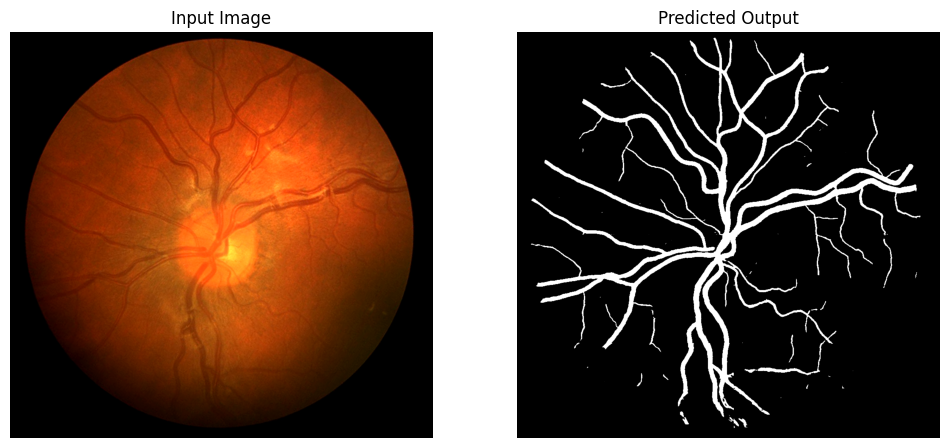

In [37]:
image = Image.open('/kaggle/input/augmented-augment/augmented_images/4faefe3c-434f-4933-8517-100cd07ccd8e.png')

# Call the predict function
predicted_image = predict(model, image, preprocess_transform, pad_transform)

In [ ]:
import shutil

# Replace "logs" with the name of your logs directory if it's different
shutil.make_archive("/kaggle/working/logs", 'zip', "logs")